In [7]:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx



from SALib.analyze import sobol


In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

2.0.2
3.1


In [18]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

from ema_workbench.em_framework.salib_samplers import get_SALib_problem


In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
# our objective= minimize total costs

''''
2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties (choose this)
4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs (choose this)
'''
dike_model, planning_steps = get_model_for_problem_formulation(2)


In [17]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# location dependent parameters
# Bmax = final breach width (absolute)
# pfail = dike failure probability
# Brate = Breach width model (relative) /day
# ID_flood wafe shape

#discount rate Multiple Decision Points: The dike_model likely involves multiple decision points or stages over time. Each discount rate parameter can correspond to a specific decision point or phase in the model. For example, discount rate 0 may be associated with immediate costs and benefits, discount rate 1 with short-term impacts, and discount rate 2 with long-term consequences. This allows for evaluating the sensitivity of decisions and outcomes to varying discount rates at different stages.


CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [6]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary


# Each lever has a specific name and range of values denoted by the indexes. Let's break down the levers and their indexes: The indexes indicate the available options or levels for each lever. For example, the '0_RfR 0' lever has two options: 0 and 1. Similarly, the 'A.1_DikeIncrease 0' lever has eleven options from 0 to 10. The specific index value chosen for each lever determines the level or intensity of the intervention applied during the model simulation.
#Rfr: different project:switch on 1 off 0
#Dike_increase: different intensity in dike increase 0 to 10

for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [7]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x0000027C5EB7AE80>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x0000027C5EB7AE80>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x0000027C5EB7AE80>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x0000027C5EB7AE80>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

In [8]:
# running the model through EMA workbench
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=200, policies=4)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 200 scenarios * 4 policies * 1 model(s) = 800 experiments
100%|████████████████████████████████████████| 800/800 [02:52<00:00,  4.63it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [ ]:
# observing the simulation runs
experiments, outcomes = results
print(outcomes.keys())


# Location dependent
# total costs
# expected number ot deaths
# RfR Total Costs
# Expected Evacuation costs



In [ ]:
# only works because we have scalar outcomes
sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()
plt.savefig('outcomes vs outcome')

In [ ]:
# plot here outcome vs. outcome dependend on policy

policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()



In [ ]:
experiments_df = pd.DataFrame.from_dict(experiments)

#apply filter
experiments_df[experiments_df['policy']==0]

In [ ]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations

# BAU = Rfr (x,t) ; Dike increase (x,t) =0
# Dike heightening scenario RFR=0 Dike heigth = 5
#


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
    Policy(
        "Dike Increase medium",
        **dict(get_do_nothing_dict(),
                **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':5,
                  'A.1_DikeIncrease 2':5,
                  'A.2_DikeIncrease 0':5,
                  'A.2_DikeIncrease 1':5,
                  'A.2_DikeIncrease 2':5,
                  'A.3_DikeIncrease 0':5,
                  'A.3_DikeIncrease 1':5,
                  'A.3_DikeIncrease 2':5,
                  'A.4_DikeIncrease 0':5,
                  'A.4_DikeIncrease 1':5,
                  'A.4_DikeIncrease 2':5,
                  'A.5_DikeIncrease 0':5,
                  'A.5_DikeIncrease 1':5,
                  'A.5_DikeIncrease 2':5})
    ),
    Policy(
        "Dike Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':10,
                  'A.1_DikeIncrease 2':10,
                  'A.2_DikeIncrease 0':10,
                  'A.2_DikeIncrease 1':10,
                  'A.2_DikeIncrease 2':10,
                  'A.3_DikeIncrease 0':10,
                  'A.3_DikeIncrease 1':10,
                  'A.3_DikeIncrease 2':10,
                  'A.4_DikeIncrease 0':10,
                  'A.4_DikeIncrease 1':10,
                  'A.4_DikeIncrease 2':10,
                  'A.5_DikeIncrease 0':10,
                  'A.5_DikeIncrease 1':10,
                  'A.5_DikeIncrease 2':10}
        )
    ),
]

In [ ]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

In [ ]:
experiments, outcomes = results

In [ ]:
# only works because we have scalar outcomes
pd.DataFrame(outcomes)

In [ ]:
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()
plt.savefig('outcome vs outcome first experiments')




In [9]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem






{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [5]:
'''
Sensitivity Analysis of the Uncertainty space respective to the Outcome
'''


sa_senarios=1000

with MultiprocessingEvaluator(dike_model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=sa_senarios,policies=1, uncertainty_sampling=Samplers.SOBOL)


[MainProcess/INFO] pool started with 8 workers
C:\Users\admin\Documents\GitHub\MBDM_Group5\venv\Lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|██████████████████████████████████| 40000/40000 [2:15:48<00:00,  4.91it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [15]:
experiments_sa, outcomes_sa = sa_results

outcomes_sa_df= pd.DataFrame.from_dict(outcomes_sa)

# safe outcomes to csv / json
outcomes_sa_df.to_json('sobol experiment outcomes_1000 scenarios')




In [46]:
'Do sensitivity Analysis for uncertainty space outcome'
outcomes_sa_col = outcomes_sa_df.columns

problem = get_SALib_problem(uncertainties)

results_Si =dict()

for item in outcomes_sa_df.columns:
    results_Si[item] = sobol.analyze(problem, outcomes_sa[item], calc_second_order=True, print_to_console=True, parallel=True)



                                   ST       ST_conf
A.0_ID flood wave shape  7.652054e-03  2.918415e-03
A.1_Bmax                 3.378773e-05  4.774138e-05
A.1_Brate                4.111191e-07  6.040091e-07
A.1_pfail                5.478322e-01  1.658959e-01
A.2_Bmax                 1.749353e-04  1.079406e-04
A.2_Brate                2.545411e-05  3.360461e-05
A.2_pfail                4.035072e-01  1.121528e-01
A.3_Bmax                 7.313456e-07  1.655655e-06
A.3_Brate                0.000000e+00  0.000000e+00
A.3_pfail                7.297128e-04  7.015491e-04
A.4_Bmax                 0.000000e+00  0.000000e+00
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                4.215829e-06  4.271503e-06
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                1.165091e-01  4.833569e-02
discount rate 0          7.142597e-02  4.006870e-02
discount rate 1          5.606402e-05  4.723898e-05
discount rat

C:\Users\admin\Documents\GitHub\MBDM_Group5\venv\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

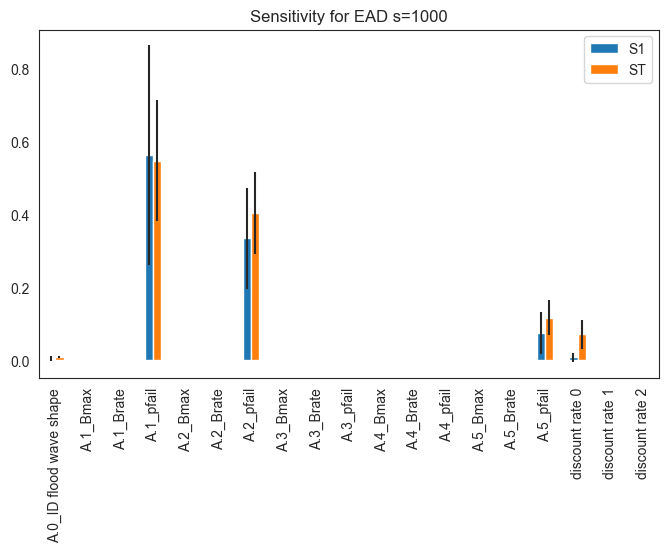

In [49]:
Si_filter = {k:results_Si['Expected Annual Damage'][k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.title('Sensitivity for EAD s=1000')
plt.show()

In [42]:
'Define a boundary for ST min that is considered for analysis.'

imp_uncer = Si_df[Si_df['ST']>0.01]

print(imp_uncer.index)

Index(['A.1_pfail', 'A.2_pfail', 'A.5_pfail', 'discount rate 0'], dtype='object')
